# 导入相关软件包

In [1]:
import scipy.io as sio

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 参数配置

In [3]:
config_para = {
    'data_path':'./spikewave.mat',
    
    'seed':42,
}

In [4]:
# 随机种子
def seed_pytorch(seed, ifDeep=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # if(ifDeep):
    #     torch.manual_seed(seed)
    #     if torch.cuda.is_available():
    #         torch.cuda.manual_seed(seed)
    #         torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    #     torch.backends.cudnn.deterministic = True  # 保证每次结果相同
    #     torch.backends.cudnn.benchmark = False  # 保证每次结果相同

In [5]:
seed_pytorch(config_para['seed'])

# 数据读入（原有read_spikes_mat.ipynb的内容）

In [6]:
data = sio.loadmat(config_para['data_path'])

In [7]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Nov 08 15:46:15 2005', '__version__': '1.0', '__globals__': [], 'wave': array([[-60, 126,  15, ..., 195, 121,  -7],
       [-13, 174,  13, ..., 204, 176,  71],
       [ 37, 223,  54, ..., 176, 212, 177],
       ...,
       [-55,  67,  11, ..., -31,  25, 164],
       [-59,  57,  10, ..., -18,  12, 160],
       [-56,  65,   6, ..., -10,   7, 120]], dtype=int16)}


In [8]:
spike_data=data['wave']
print(spike_data.shape)

(40, 5376)


In [9]:
# 转置一下，使array符合常规的（样本点，维度）结构
features = spike_data.T
# feature
features.shape

(5376, 40)

# 1. 把这些 spike 波形叠画在一起，观察并描述它们的可分性

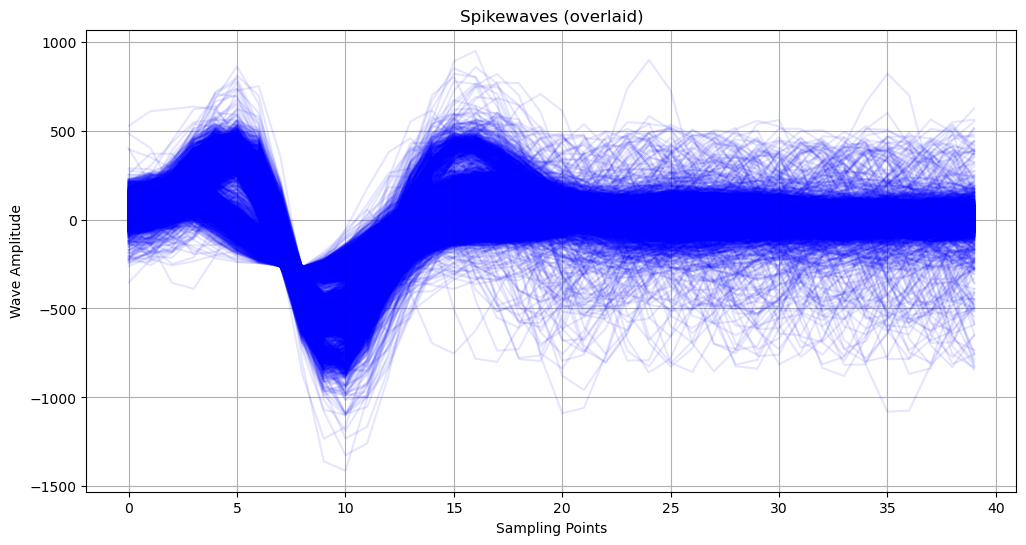

In [10]:
# 以采样点为索引，每次叠画所有波形的图像
plt.figure(figsize=(12, 6))
time_points = np.arange(40)
for i in range(features.shape[0]):
    plt.plot(time_points, features[i, :], 'b-', alpha=0.1) # 合在一起
plt.title('Spikewaves (overlaid)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.grid(True)
plt.show()

# 2. 用 PCA 方法把这些 spike 分别降维到 2 维和 3 维空间，并画出来

## 初始化和基础分析

In [11]:
# 初始化pca
pca = PCA() # 因为要做两次降维，所以先计算每个主成分的方差，后续再根据维度要求进行筛选即可（不单独指定n_components了）

features_pca = pca.fit_transform(features)

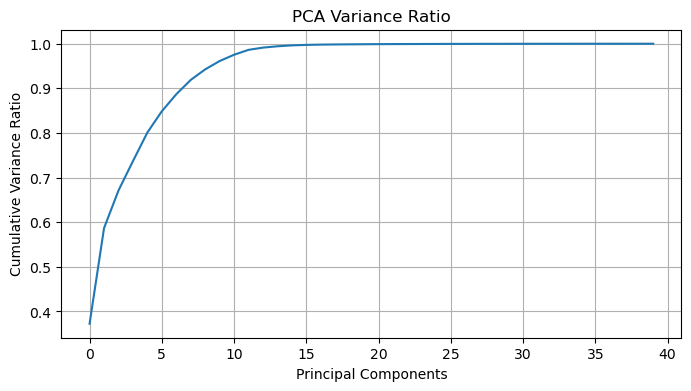

In [12]:
# 分析一下每个主成分的方差/特征值比率，并绘制曲线图
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance Ratio')
plt.title('PCA Variance Ratio')
plt.grid(True)
plt.show()

## 降维到2维并可视化

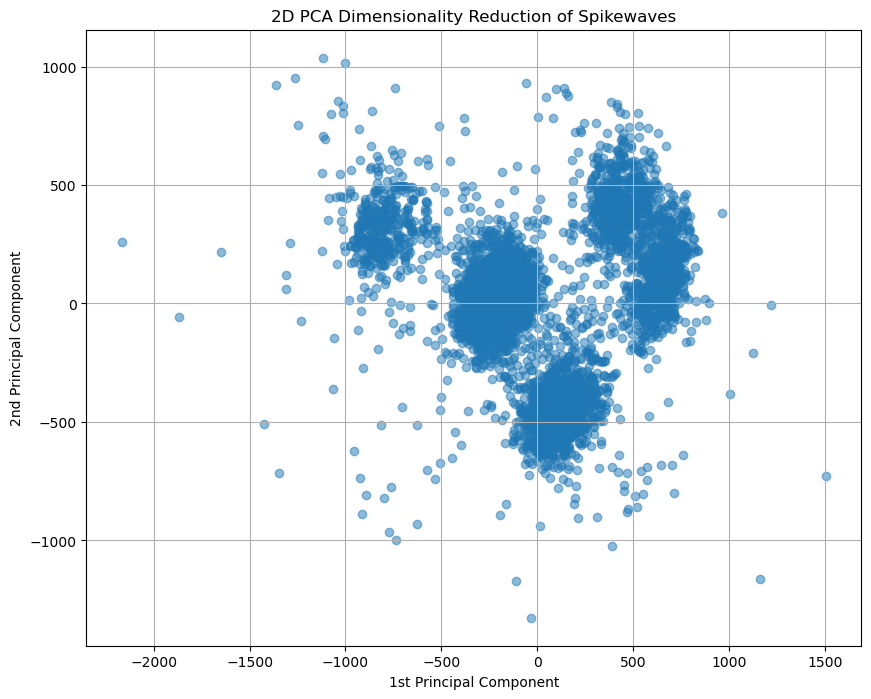

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.5)
plt.title('2D PCA Dimensionality Reduction of Spikewaves')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.grid(True)
plt.show()

## 降维到3维并可视化

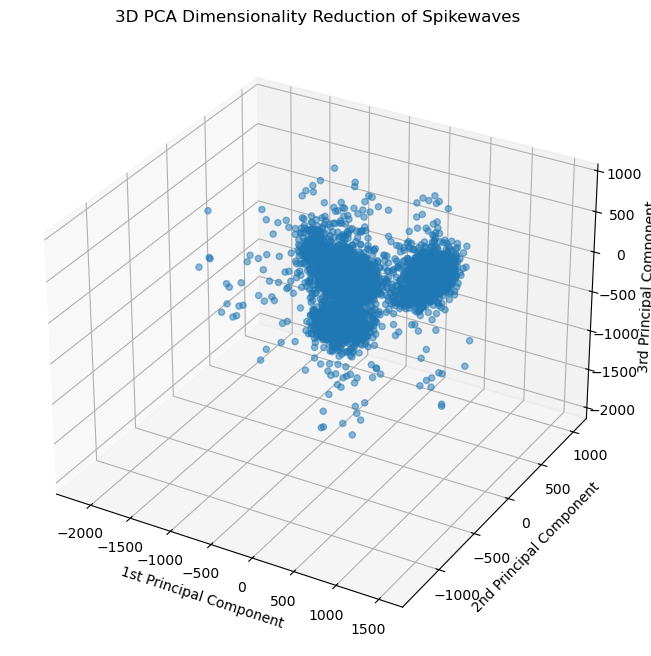

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
plt.title('3D PCA Dimensionality Reduction of Spikewaves')
plt.show()

# 3. 在 2 维和 3 维空间分别采用合适的聚类方法把它们分成合理类别，这些类别就对应于临近的神经细胞放电

## K-Means聚类

In [15]:
# 先提取不同维度的主成分
features_pca_2d = features_pca[:, :2]
features_pca_3d = features_pca[:, :3]

### 确定最优聚类数：轮廓系数

In [16]:
from sklearn.metrics import silhouette_score

In [17]:
# 2d和3d情况分别计算
silhouette_scores_2d = []
silhouette_scores_3d = []
K_range = range(2, 7)

In [18]:
# 计算轮廓系数：2d
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config_para['seed'])
    cluster_labels_2d = kmeans.fit_predict(features_pca_2d)
    silhouette_avg_2d = silhouette_score(features_pca_2d, cluster_labels_2d)
    silhouette_scores_2d.append(silhouette_avg_2d)

d:\anaconda3\envs\pytorch_tf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\envs\pytorch_tf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pytorch_tf\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pytorch_tf\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\anaconda3\envs\pytorch_tf\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

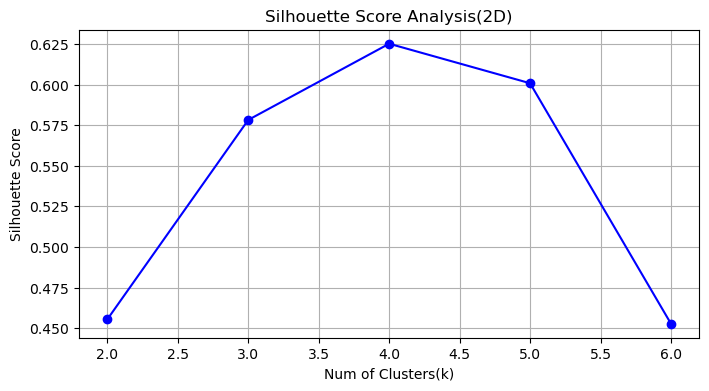

In [19]:
# 查看最优聚类数：2d
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), silhouette_scores_2d, 'bo-')
plt.xlabel('Num of Clusters(k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis(2D)')
plt.grid(True)
plt.show()

In [20]:
# 计算轮廓系数：3d
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config_para['seed'])
    cluster_labels_3d = kmeans.fit_predict(features_pca_3d)
    silhouette_avg_3d = silhouette_score(features_pca_3d, cluster_labels_3d)
    silhouette_scores_3d.append(silhouette_avg_3d)

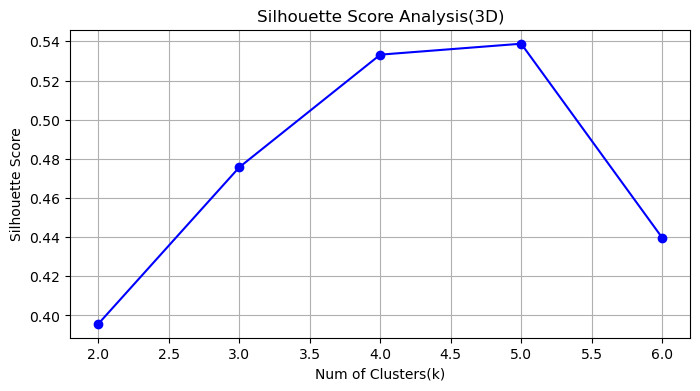

In [21]:
# 查看最优聚类数：3d
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), silhouette_scores_3d, 'bo-')
plt.xlabel('Num of Clusters(k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis(3D)')
plt.grid(True)
plt.show()

In [22]:
# 确定最优聚类数
optimal_k_ss_2d = K_range[np.argmax(silhouette_scores_2d)]
optimal_k_ss_3d = K_range[np.argmax(silhouette_scores_3d)]

In [23]:
optimal_k_ss_2d, optimal_k_ss_3d

(4, 5)

### 确定最优聚类数：肘部法

In [24]:
# 2d和3d情况分别计算
elbow_scores_2d = []
elbow_scores_3d = []
K_range = range(2, 7)

In [25]:
# 计算类间平方和wss：2d
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config_para['seed'])
    cluster_labels_2d = kmeans.fit_predict(features_pca_2d)
    elbow_scores_2d.append(kmeans.inertia_)

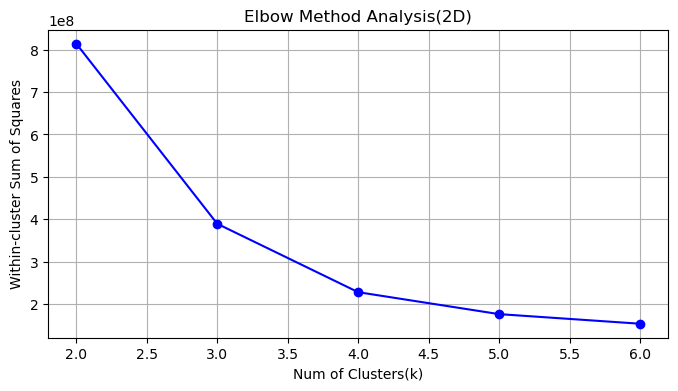

In [26]:
# 查看类间平方和wss：2d
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), elbow_scores_2d, 'bo-')
plt.xlabel('Num of Clusters(k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Method Analysis(2D)')
plt.grid(True)
plt.show()

In [27]:
# 计算类间平方和wss：3d
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config_para['seed'])
    cluster_labels_3d = kmeans.fit_predict(features_pca_3d)
    elbow_scores_3d.append(kmeans.inertia_)

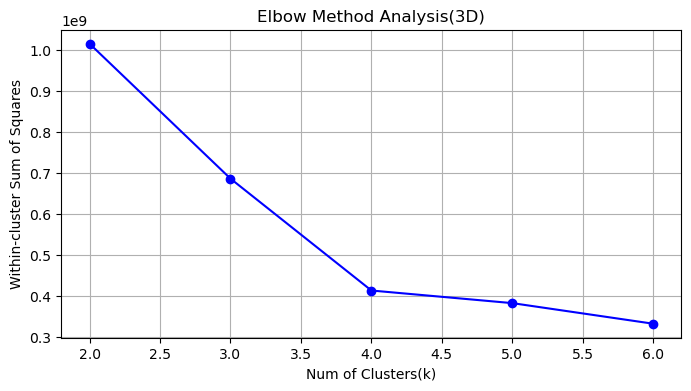

In [28]:
# 查看类间平方和wss：3d
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), elbow_scores_3d, 'bo-')
plt.xlabel('Num of Clusters(k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Method Analysis(3D)')
plt.grid(True)
plt.show()

In [29]:
# 确定最优聚类数(直接观察得)
optimal_k_em_2d = 3
optimal_k_em_3d = 4

In [30]:
optimal_k_em_2d, optimal_k_em_3d

(3, 4)

### 2维聚类

In [31]:
# 开始聚类，分别根据两种方法聚类
kmeans_2d_1 = KMeans(n_clusters=optimal_k_ss_2d, random_state=config_para['seed'])
kmeans_2d_2 = KMeans(n_clusters=optimal_k_em_2d, random_state=config_para['seed'])
clusters_2d_1 = kmeans_2d_1.fit_predict(features_pca_2d)
clusters_2d_2 = kmeans_2d_2.fit_predict(features_pca_2d)

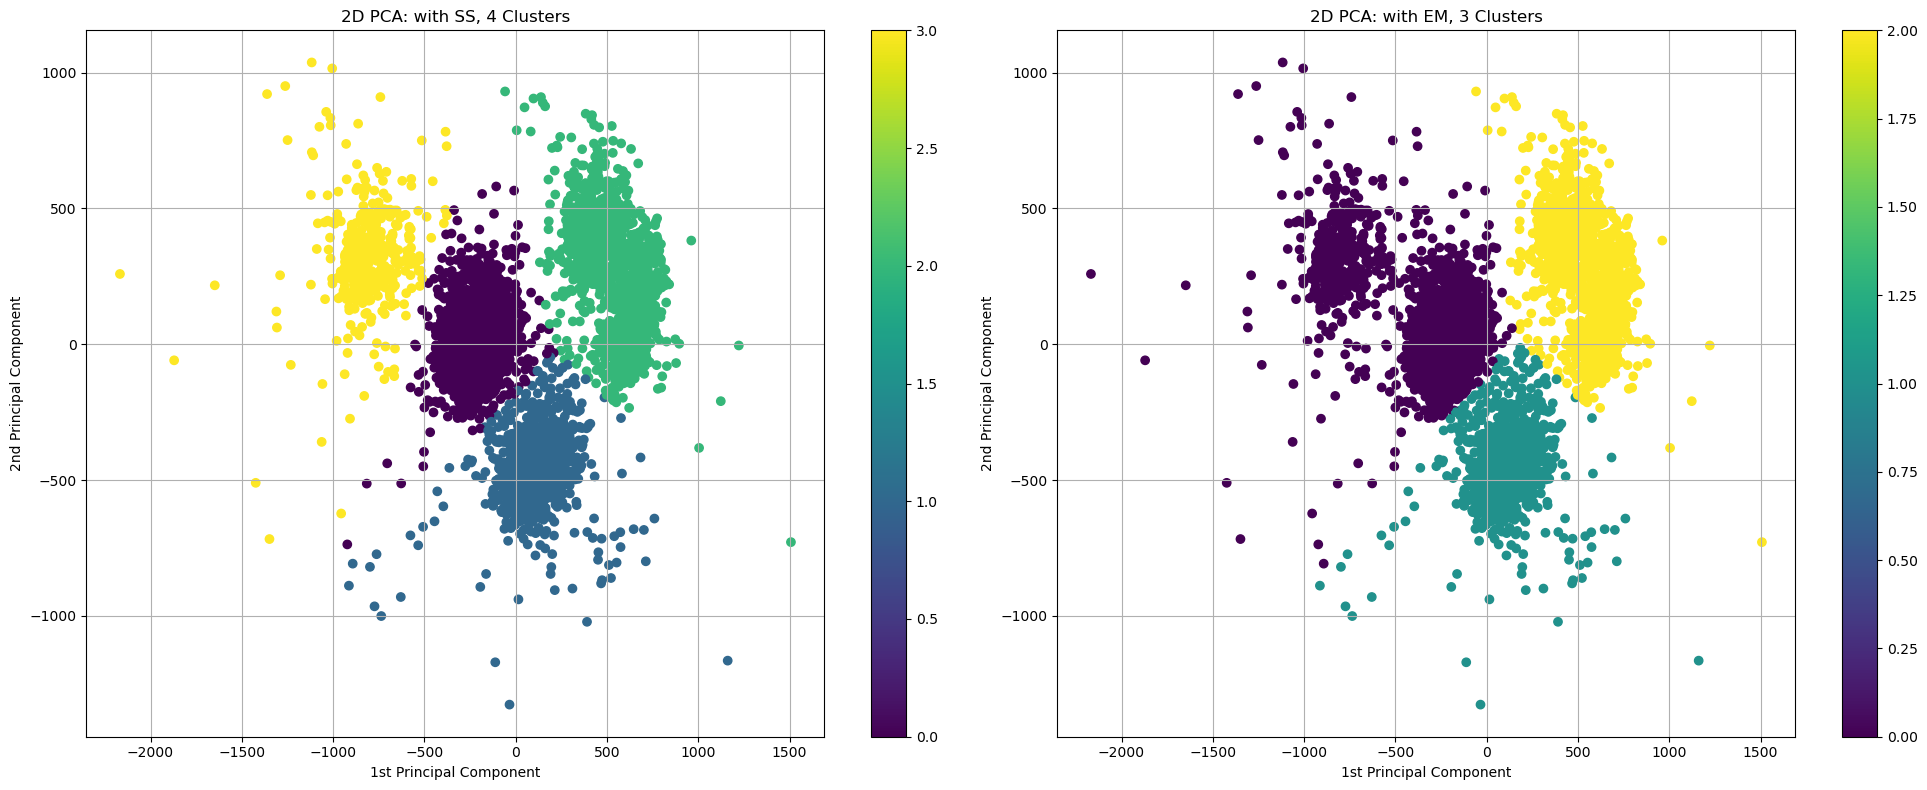

In [32]:
# 根据聚类结果可视化
plt.figure(figsize=(20, 8))

# 1. 轮廓系数
plt.subplot(1, 2, 1)
scatter_1 = plt.scatter(features_pca_2d[:,0], features_pca_2d[:,1], c=clusters_2d_1, cmap='viridis')
plt.colorbar(scatter_1)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title(f'2D PCA: with SS, {optimal_k_ss_2d} Clusters')
plt.grid(True)

# 2. 肘部法
plt.subplot(1, 2, 2)
scatter_2 = plt.scatter(features_pca_2d[:,0], features_pca_2d[:,1], c=clusters_2d_2, cmap='viridis')
plt.colorbar(scatter_2)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title(f'2D PCA: with EM, {optimal_k_em_2d} Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

### 3维聚类

In [33]:
# 开始聚类，分别根据两种方法聚类
kmeans_3d_1 = KMeans(n_clusters=optimal_k_ss_3d, random_state=config_para['seed'])
kmeans_3d_2 = KMeans(n_clusters=optimal_k_em_3d, random_state=config_para['seed'])
clusters_3d_1 = kmeans_3d_1.fit_predict(features_pca_3d)
clusters_3d_2 = kmeans_3d_2.fit_predict(features_pca_3d)

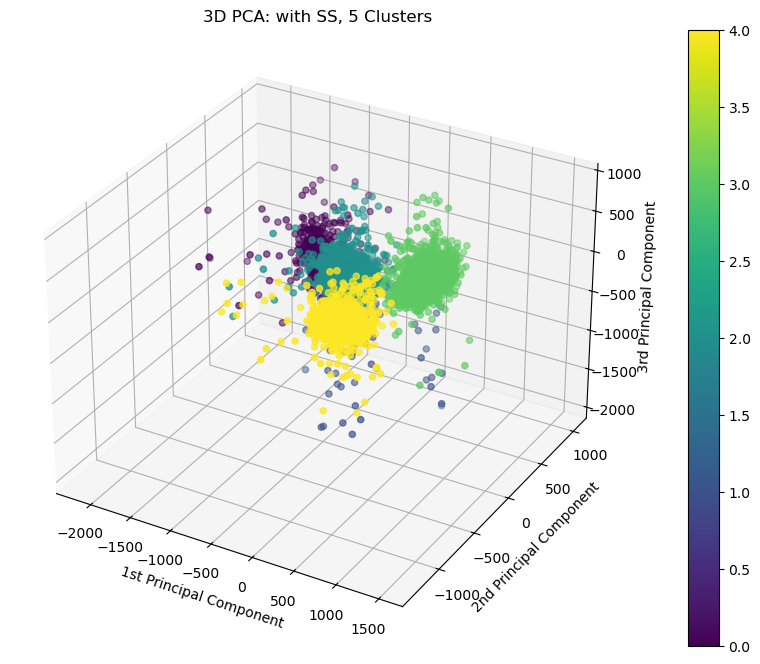

In [34]:
# 根据聚类结果可视化
fig1 = plt.figure(figsize=(16, 8))

# 1. 轮廓系数
ax_1 = fig1.add_subplot(111, projection='3d')
scatter_3 = ax_1.scatter(features_pca_3d[:, 0], features_pca_3d[:, 1], features_pca_3d[:, 2], 
                    c=clusters_3d_1, cmap='viridis')
plt.colorbar(scatter_3)
ax_1.set_xlabel('1st Principal Component')
ax_1.set_ylabel('2nd Principal Component')
ax_1.set_zlabel('3rd Principal Component')
ax_1.set_title(f'3D PCA: with SS, {optimal_k_ss_3d} Clusters')
ax_1.grid(True)
plt.show()

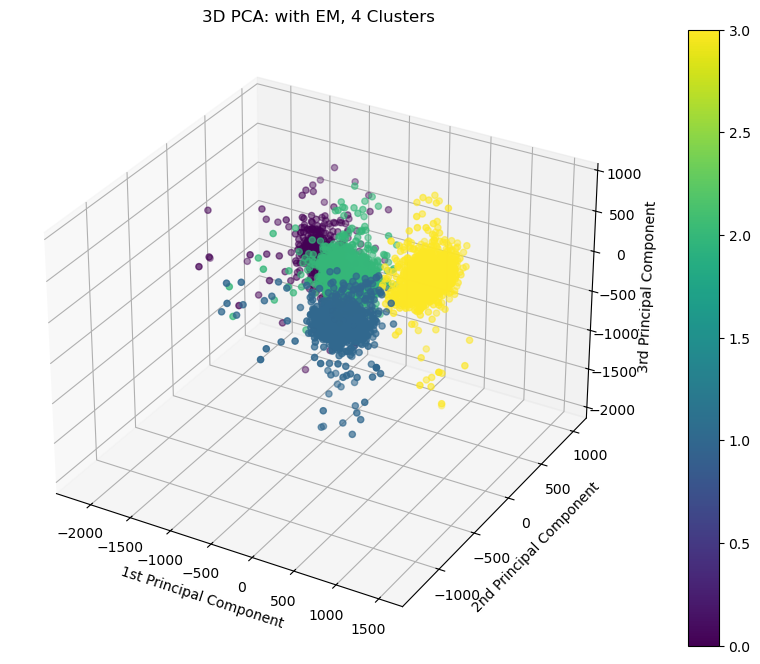

In [35]:
# 2. 肘部法
fig2 = plt.figure(figsize=(16, 8))

ax_2 = fig2.add_subplot(111, projection='3d')
scatter_4 = ax_2.scatter(features_pca_3d[:, 0], features_pca_3d[:, 1], features_pca_3d[:, 2], 
                    c=clusters_3d_2, cmap='viridis')
plt.colorbar(scatter_4)
ax_2.set_xlabel('1st Principal Component')
ax_2.set_ylabel('2nd Principal Component')
ax_2.set_zlabel('3rd Principal Component')
ax_2.set_title(f'3D PCA: with EM, {optimal_k_em_3d} Clusters')
ax_2.grid(True)
plt.show()

## DBSCAN聚类

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [37]:
# 归一化
scaler = StandardScaler()
features_pca_2d_scaled = scaler.fit_transform(features_pca_2d)
features_pca_3d_scaled = scaler.fit_transform(features_pca_3d)

In [38]:
# 初始化
dbscan = DBSCAN(eps=0.3, min_samples=5)

## 2维聚类

In [39]:
cluster_labels_dbscan_2d = dbscan.fit_predict(features_pca_2d_scaled)

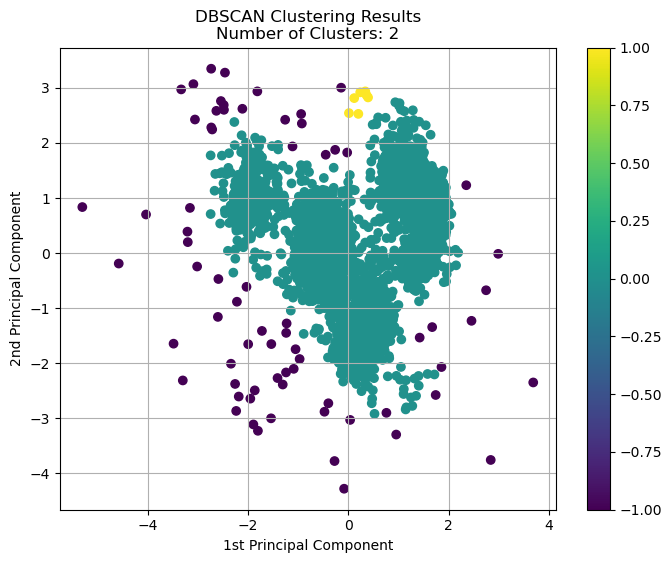

In [40]:
# 根据聚类结果可视化
plt.figure(figsize=(8, 6))

scatter_dbscan_2d = plt.scatter(features_pca_2d_scaled[:, 0], features_pca_2d_scaled[:, 1], 
                           c=cluster_labels_dbscan_2d, cmap='viridis')
plt.colorbar(scatter_dbscan_2d)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title(f'DBSCAN Clustering Results\nNumber of Clusters: {len(np.unique(cluster_labels_dbscan_2d))-1}')

plt.grid(True)
plt.show()

## 3维聚类

In [41]:
cluster_labels_dbscan_3d = dbscan.fit_predict(features_pca_3d_scaled)

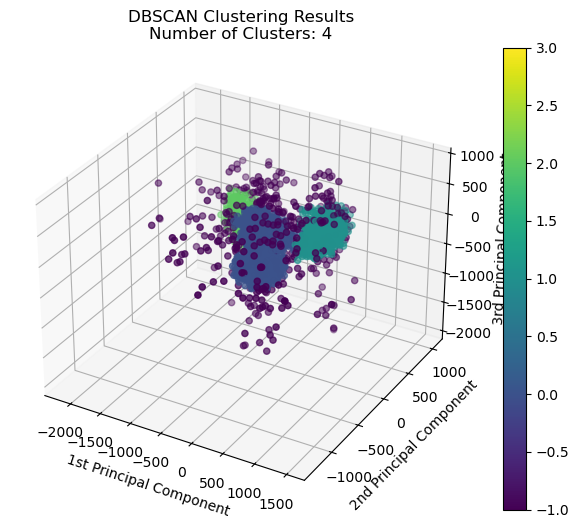

In [42]:
# 根据聚类结果可视化
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')
scatter_dbscan_3d = ax.scatter(features_pca_3d[:, 0], features_pca_3d[:, 1], features_pca_3d[:, 2], 
                    c=cluster_labels_dbscan_3d, cmap='viridis')
plt.colorbar(scatter_dbscan_3d)
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
ax.set_title(f'DBSCAN Clustering Results\nNumber of Clusters: {len(np.unique(cluster_labels_dbscan_3d))-1}')
ax_1.grid(True)
plt.show()

# 4. 把 Spike sorting 之后的波形按照神经细胞归类，用不同颜色再次叠画在一起，观察并描述它们的波形在类内和类间的差异

In [43]:
# 由上述可视化结果可知，2d和3d时都是k=4更好，分别对应2d:ss和3d:em
optimal_k = 4

## 2维聚类方案

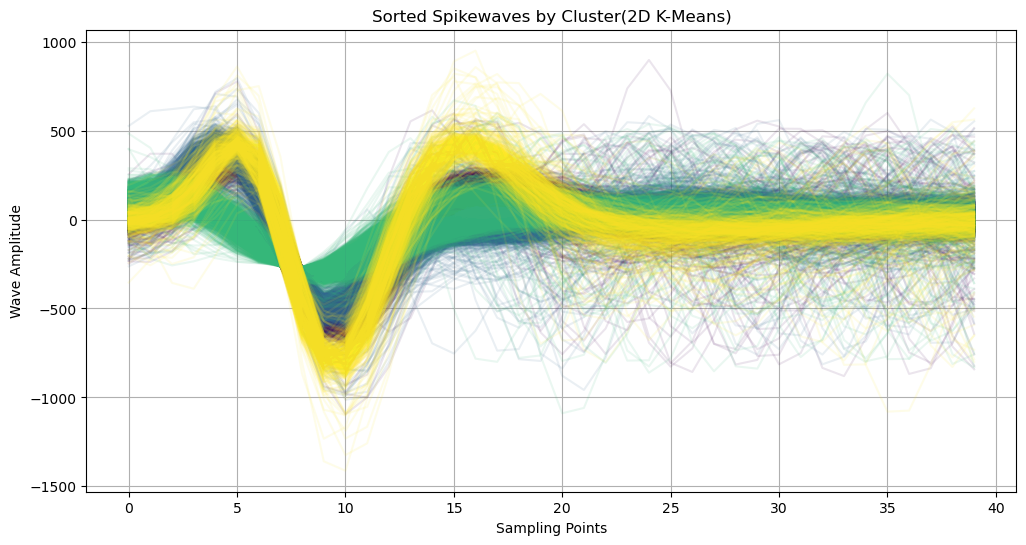

In [44]:
# 绘制所有波形
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k)) # 生成对应数量的颜色

for i in range(optimal_k):
    cluster_spikes = features[clusters_2d_1 == i]
    
    for spike in cluster_spikes:
        plt.plot(time_points, spike, color=colors[i], alpha=0.1)

plt.title('Sorted Spikewaves by Cluster(2D K-Means)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
# plt.legend()
plt.grid(True)
plt.show()

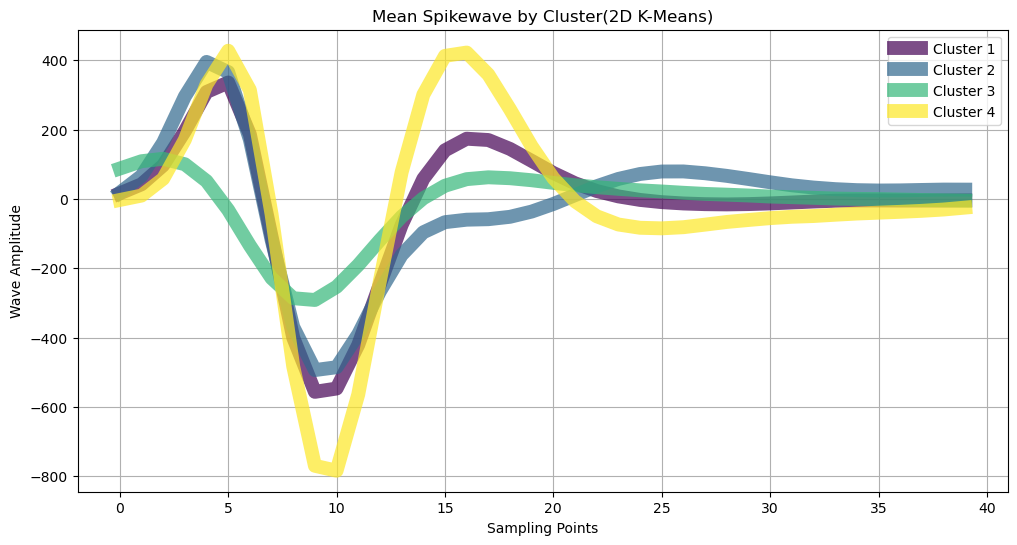

In [45]:
# 绘制每个cluster的平均波形
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k)) # 生成对应数量的颜色

for i in range(optimal_k):
    cluster_spikes = features[clusters_2d_1 == i]
    # 求每个cluster的平均spikewave
    mean_spike = np.mean(cluster_spikes, axis=0)
    plt.plot(time_points, mean_spike, color=colors[i], alpha=0.7, linewidth=10, 
             label=f'Cluster {i+1}')

plt.title('Mean Spikewave by Cluster(2D K-Means)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## 3维聚类方案

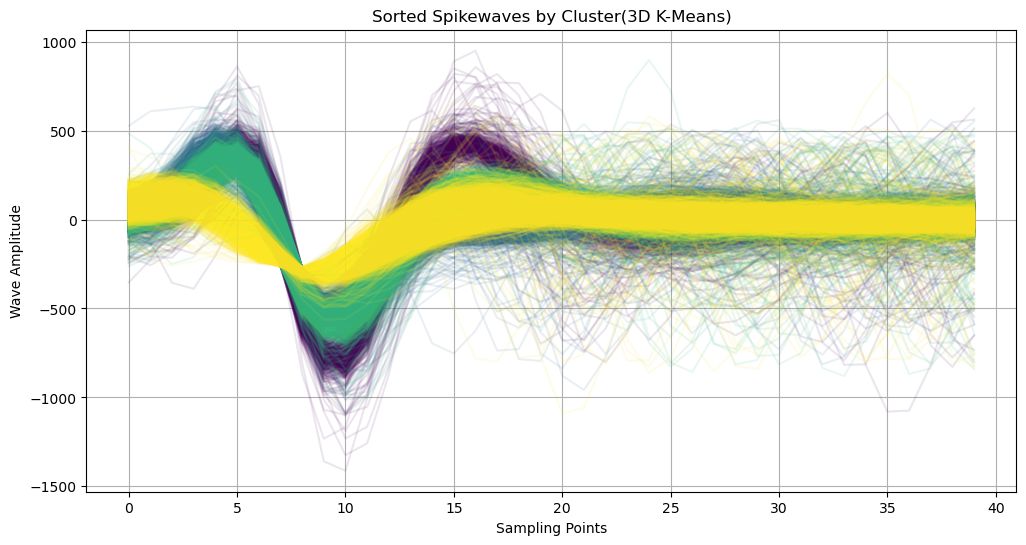

In [46]:
# 绘制所有波形
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k)) # 生成对应数量的颜色

for i in range(optimal_k):
    cluster_spikes = features[clusters_3d_2 == i]
    
    for spike in cluster_spikes:
        plt.plot(time_points, spike, color=colors[i], alpha=0.1)

plt.title('Sorted Spikewaves by Cluster(3D K-Means)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
# plt.legend()
plt.grid(True)
plt.show()

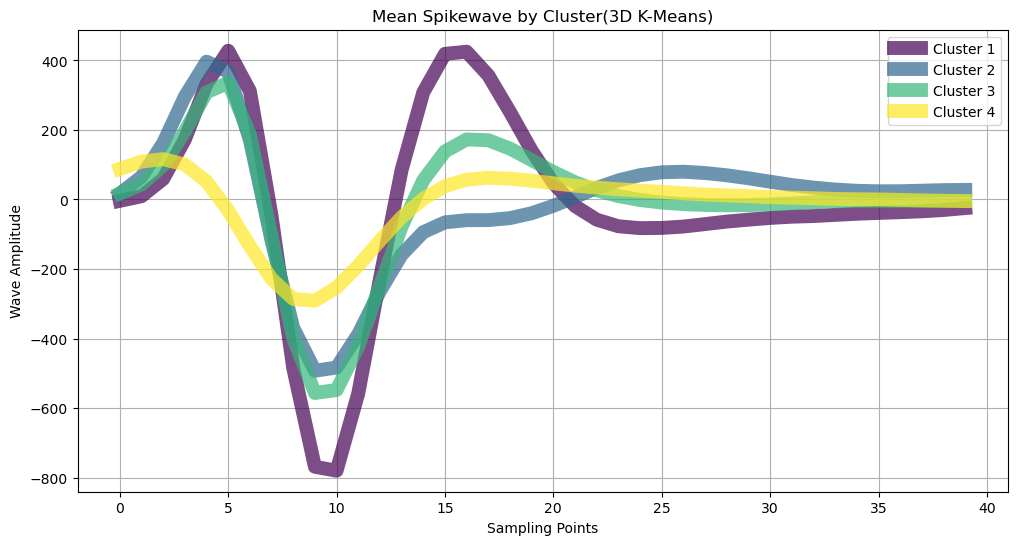

In [47]:
# 绘制每个cluster的平均波形
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k)) # 生成对应数量的颜色

for i in range(optimal_k):
    cluster_spikes = features[clusters_3d_2 == i]
    # 求每个cluster的平均spikewave
    mean_spike = np.mean(cluster_spikes, axis=0)
    plt.plot(time_points, mean_spike, color=colors[i], alpha=0.7, linewidth=10, 
             label=f'Cluster {i+1}')

plt.title('Mean Spikewave by Cluster(3D K-Means)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## DBCAN方案

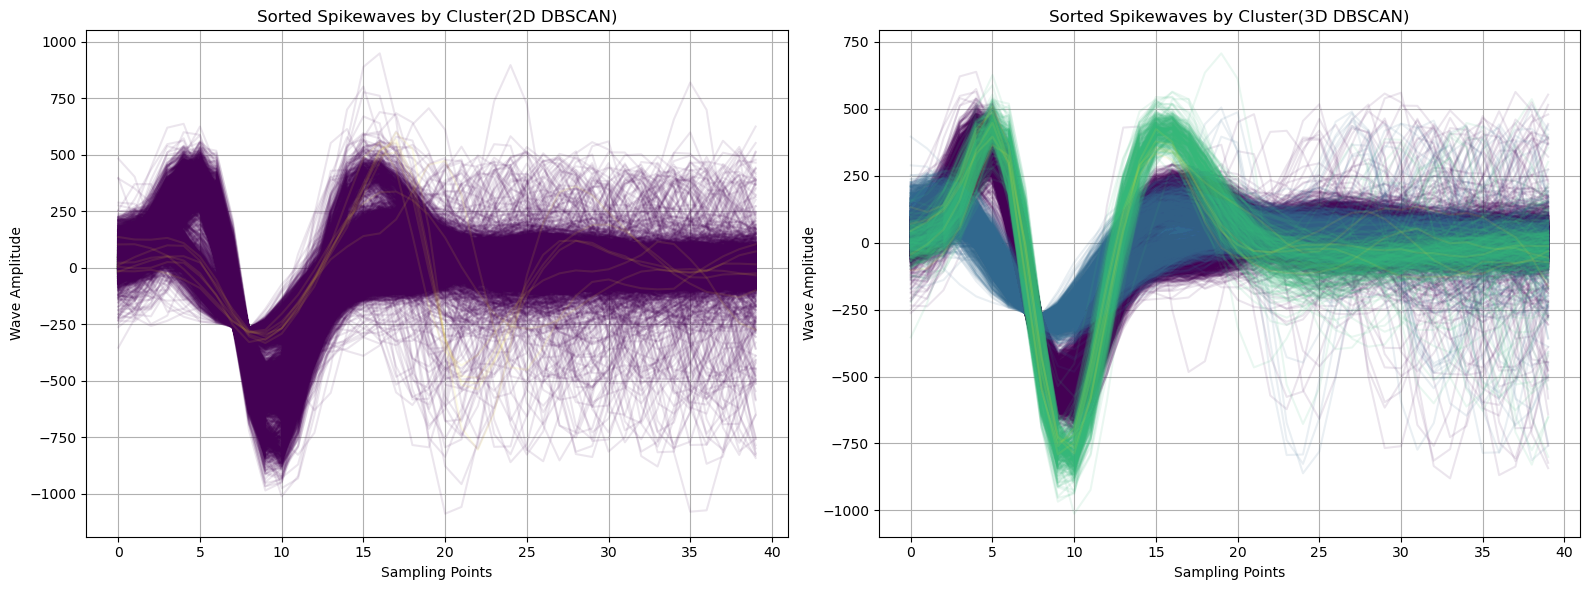

In [48]:
# 所有波形
plt.figure(figsize=(16, 6))

# 1. 2D
plt.subplot(1, 2, 1)
# 绘制添加波形
colors = plt.cm.viridis(np.linspace(0, 1, 2)) # 生成对应数量的颜色

for i in range(2):
    cluster_spikes = features[cluster_labels_dbscan_2d == i]
    
    for spike in cluster_spikes:
        plt.plot(time_points, spike, color=colors[i], alpha=0.1)

plt.title('Sorted Spikewaves by Cluster(2D DBSCAN)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.grid(True)

# 2. 3D
plt.subplot(1, 2, 2)
# 绘制添加波形
colors = plt.cm.viridis(np.linspace(0, 1, 4)) # 生成对应数量的颜色

for i in range(4):
    cluster_spikes = features[cluster_labels_dbscan_3d == i]
    
    for spike in cluster_spikes:
        plt.plot(time_points, spike, color=colors[i], alpha=0.1)

plt.title('Sorted Spikewaves by Cluster(3D DBSCAN)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

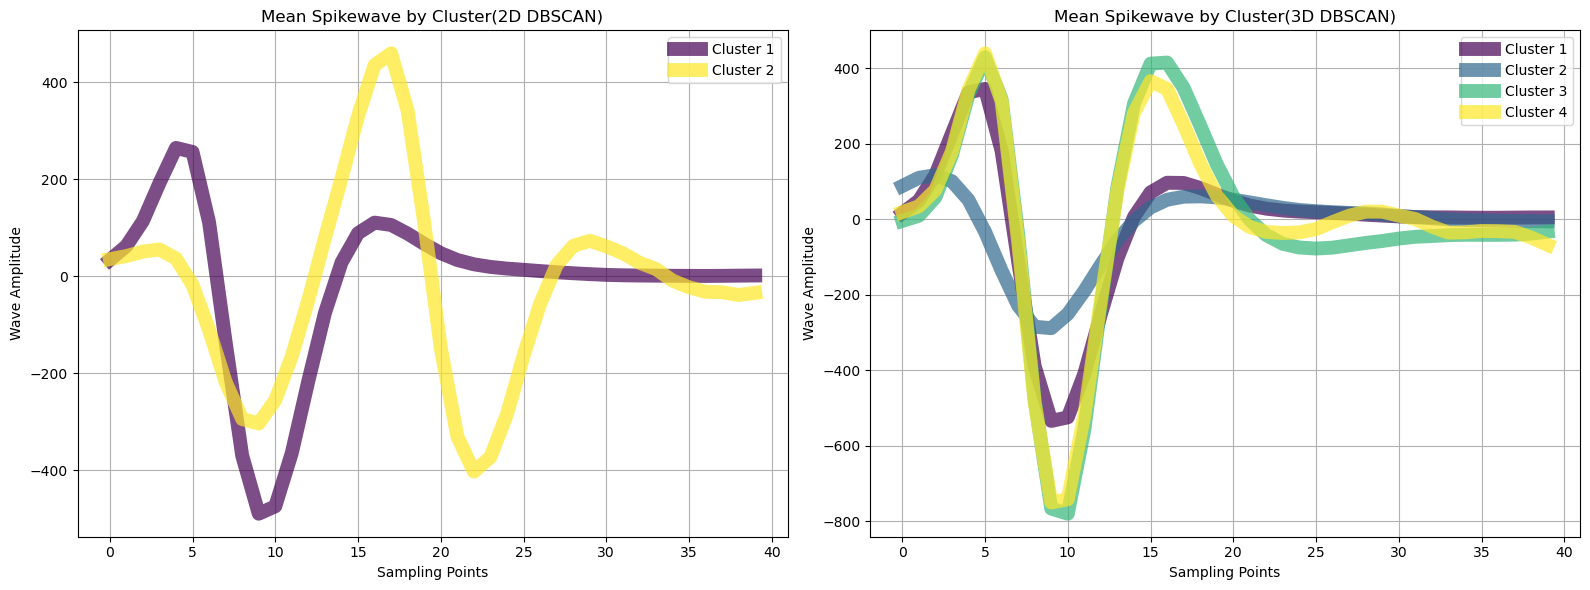

In [49]:
# 平均波形
plt.figure(figsize=(16, 6))

# 1. 2D
plt.subplot(1, 2, 1)
# 绘制添加波形
colors = plt.cm.viridis(np.linspace(0, 1, 2)) # 生成对应数量的颜色

for i in range(2):
    cluster_spikes = features[cluster_labels_dbscan_2d == i]
    
    # 求每个cluster的平均spikewave
    mean_spike = np.mean(cluster_spikes, axis=0)
    plt.plot(time_points, mean_spike, color=colors[i], alpha=0.7, linewidth=10, 
             label=f'Cluster {i+1}')

plt.title('Mean Spikewave by Cluster(2D DBSCAN)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.legend()
plt.grid(True)

# 2. 3D
plt.subplot(1, 2, 2)
# 绘制添加波形
colors = plt.cm.viridis(np.linspace(0, 1, 4)) # 生成对应数量的颜色

for i in range(4):
    cluster_spikes = features[cluster_labels_dbscan_3d == i]
    
    # 求每个cluster的平均spikewave
    mean_spike = np.mean(cluster_spikes, axis=0)
    plt.plot(time_points, mean_spike, color=colors[i], alpha=0.7, linewidth=10, 
             label=f'Cluster {i+1}')

plt.title('Mean Spikewave by Cluster(3D DBSCAN)')
plt.xlabel('Sampling Points')
plt.ylabel('Wave Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
# # Print cluster statistics
# for i in range(optimal_k):
#     cluster_spikes = features[clusters_3d == i]
#     print(f"\nCluster {i+1} Statistics:")
#     print(f"Number of spikes: {len(cluster_spikes)}")
#     print(f"Mean amplitude: {np.mean(cluster_spikes):.3f}")
#     print(f"Standard deviation: {np.std(cluster_spikes):.3f}")